In [12]:
import os

# Define paths
DATA_RAW = "../data/raw/"
DATA_PROCESSED = "../data/processed/"

# Make sure directories exist
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PROCESSED, exist_ok=True)

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Load dataset
df = pd.read_csv(os.path.join(DATA_RAW, "stroke_risk.csv"))

print("Initial shape:", df.shape)
print("Initial columns:", df.columns.tolist())
print(df.head())

Initial shape: (35000, 19)
Initial columns: ['age', 'gender', 'chest_pain', 'high_blood_pressure', 'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness', 'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating', 'persistent_cough', 'nausea_vomiting', 'chest_discomfort', 'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom', 'stroke_risk_percentage', 'at_risk']
   age  gender chest_pain high_blood_pressure irregular_heartbeat  \
0   22    Male        Yes                  No                  No   
1   52    Male         No                 Yes                 Yes   
2   63  Female         No                 Yes                  No   
3   41    Male         No                  No                 Yes   
4   53    Male         No                  No                  No   

  shortness_of_breath fatigue_weakness dizziness swelling_edema neck_jaw_pain  \
0                  No               No        No             No            No   
1                  No             

Missing values in each column:
 age                       0
gender                    0
chest_pain                0
high_blood_pressure       0
irregular_heartbeat       0
shortness_of_breath       0
fatigue_weakness          0
dizziness                 0
swelling_edema            0
neck_jaw_pain             0
excessive_sweating        0
persistent_cough          0
nausea_vomiting           0
chest_discomfort          0
cold_hands_feet           0
snoring_sleep_apnea       0
anxiety_doom              0
stroke_risk_percentage    0
at_risk                   0
dtype: int64

Total missing values in dataset: 0


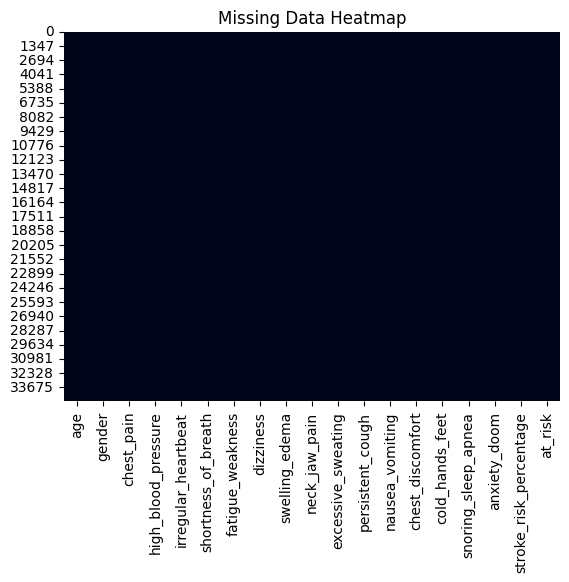

In [15]:
# check missing values

missing = df.isna().sum()
print("Missing values in each column:\n", missing)
total_missing = df.isna().sum().sum()
print(f"\nTotal missing values in dataset: {total_missing}")

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

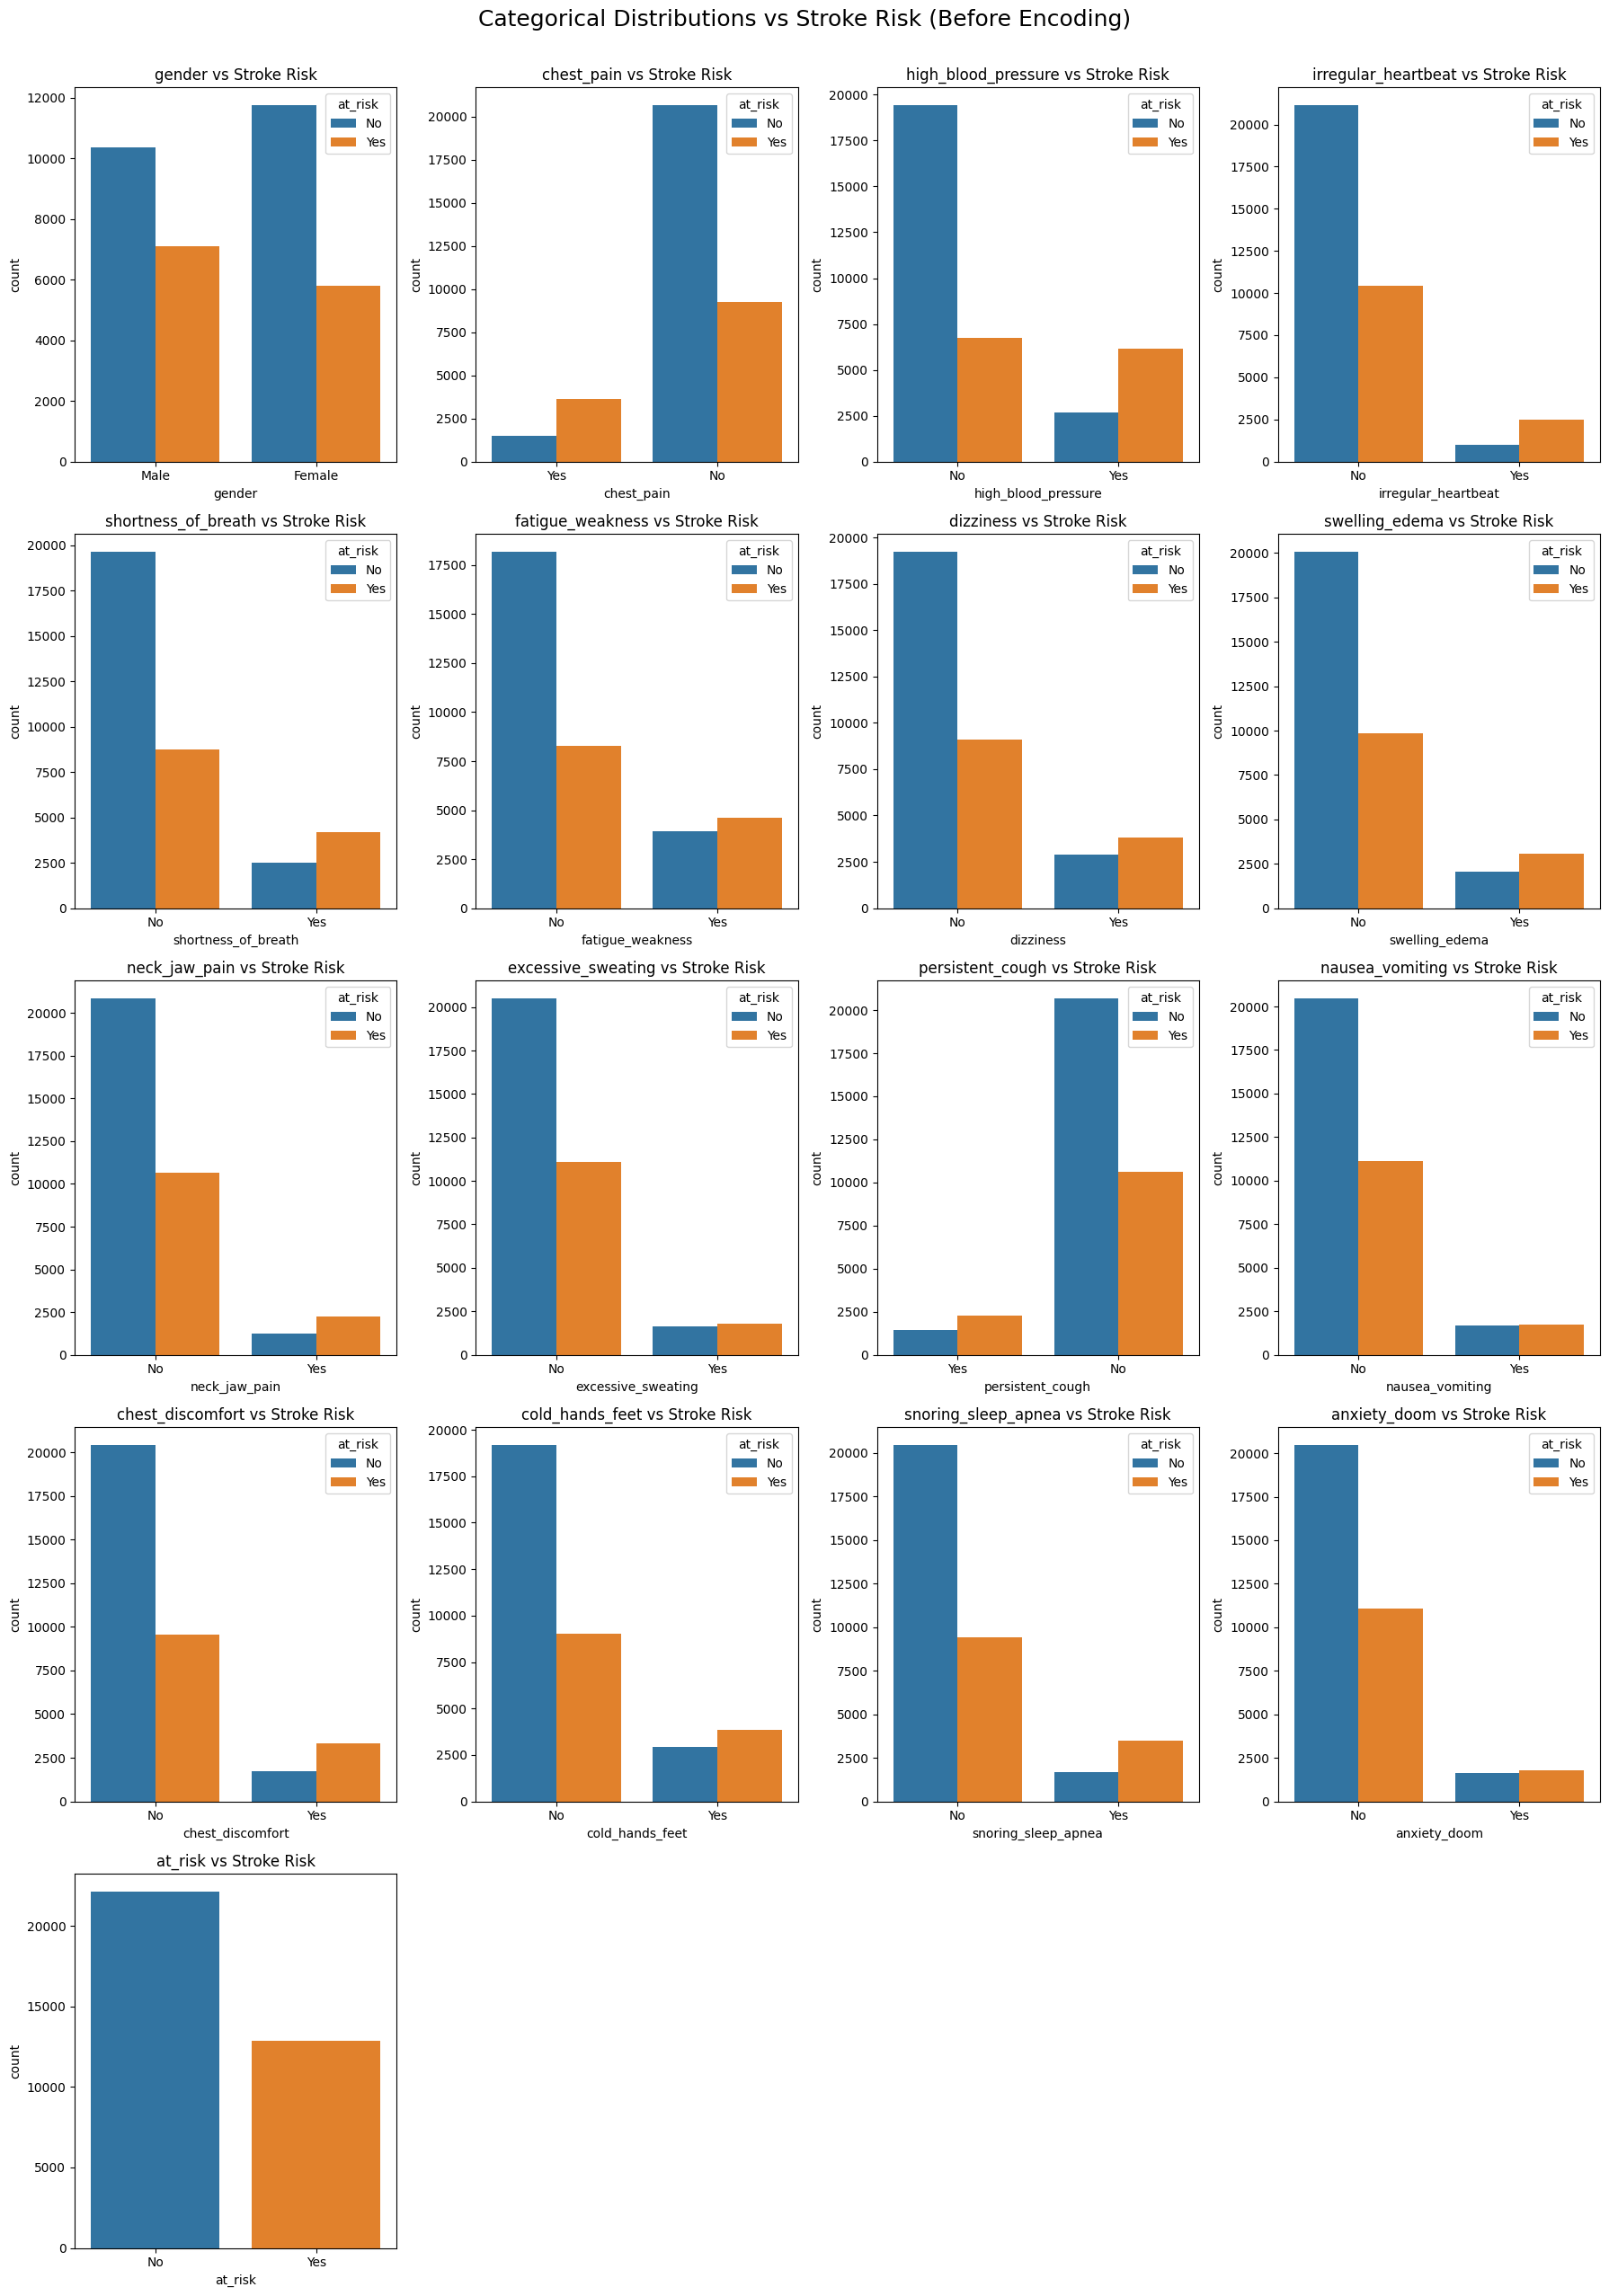

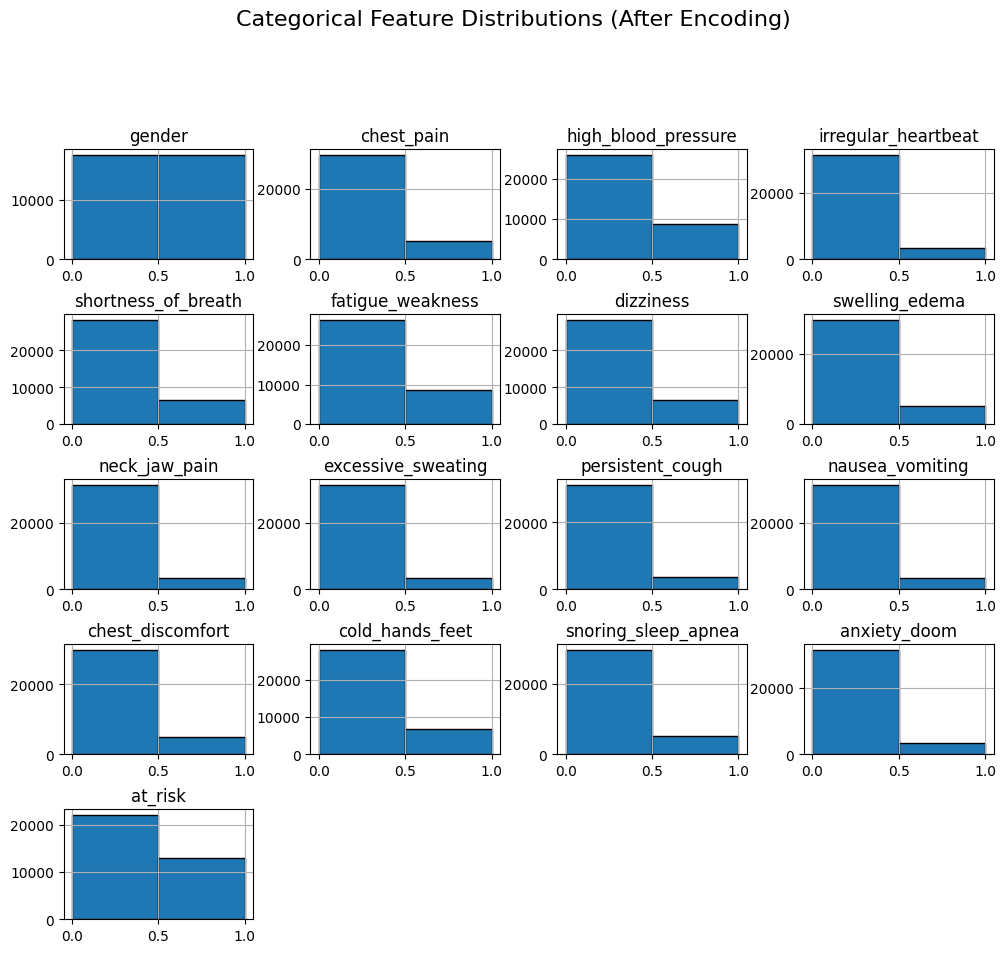

In [16]:
# Encoding

object_cols = df.select_dtypes(include=['object', 'category']).columns

# Before encoding visualization
if len(object_cols) == 0:
    print("No categorical columns left to plot")
else:
    n_cols = 4
    n_rows = (len(object_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(object_cols):
        sns.countplot(data=df, x=col, hue="at_risk", ax=axes[i])
        axes[i].set_title(f"{col} vs Stroke Risk")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Categorical Distributions vs Stroke Risk (Before Encoding)", fontsize=18, y=1.02)
    plt.show()

# Encode categ to numeric
mapping = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0
}

for col in object_cols:
    df[col] = df[col].map(mapping)

print("\n")
# After Encoding Visualization
df[object_cols].hist(figsize=(12, 10), bins=2, edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Categorical Feature Distributions (After Encoding)", fontsize=16, y=1.02)
plt.show()

age -> 238 outliers detected
stroke_risk_percentage -> 0 outliers detected


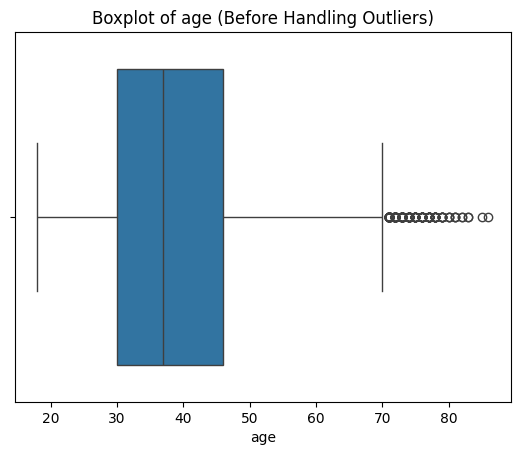

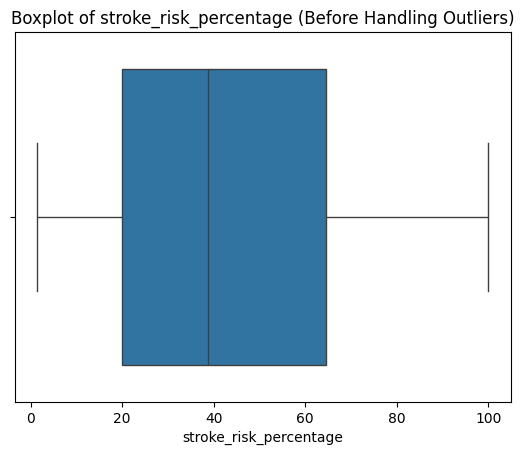

In [17]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 2]

# Outlier Detection with IQR
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

for col in continuous_cols:
    outliers = detect_outliers(df[col])
    print(f"{col} -> {len(outliers)} outliers detected")

for col in continuous_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (Before Handling Outliers)")
    plt.show()


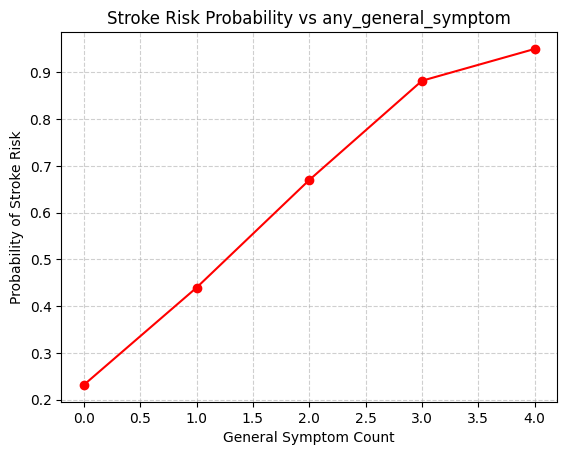

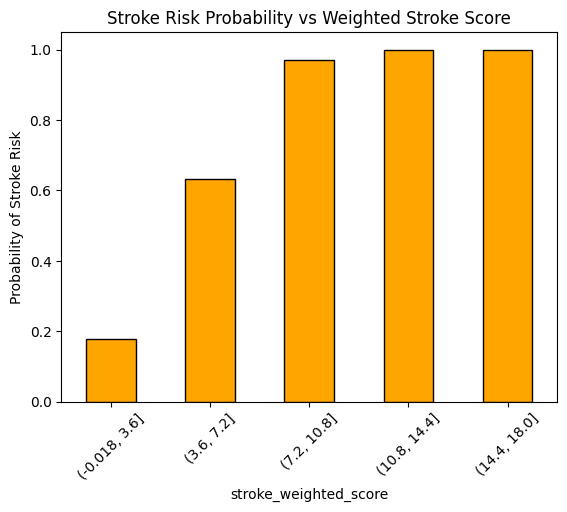

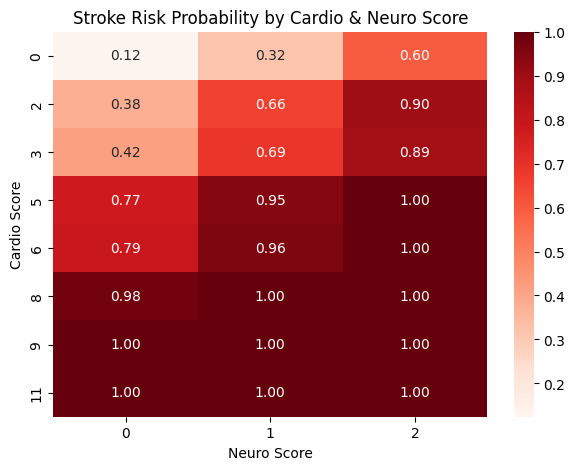

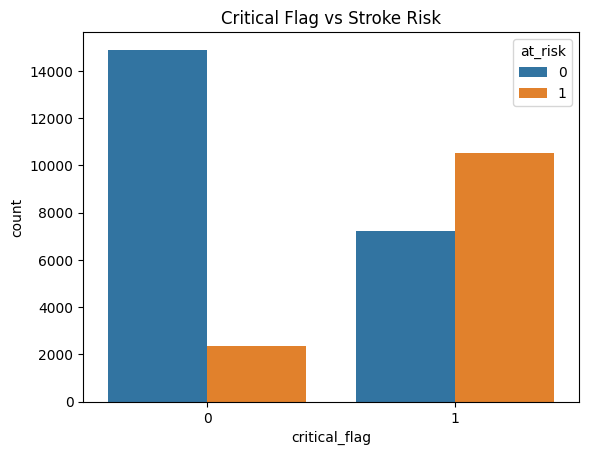

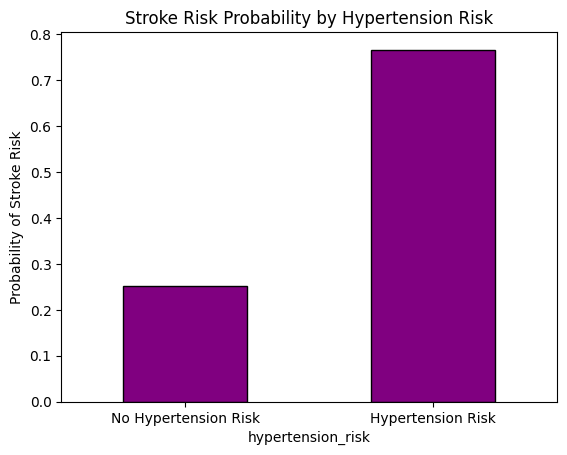

In [18]:
#Feature Engineering 

df = df.drop(columns=['stroke_risk_percentage'])

# General Symptoms
general_symptoms = ['persistent_cough','cold_hands_feet','anxiety_doom','fatigue_weakness']
df['general_symptom_count'] = df[general_symptoms].sum(axis=1)
df['any_general_symptom'] = (df['general_symptom_count'] > 0).astype(int)

# Visualization
symptom_risk = df.groupby('general_symptom_count')['at_risk'].mean()

plt.plot(symptom_risk.index, symptom_risk.values, marker='o', color='red')
plt.title("Stroke Risk Probability vs any_general_symptom")
plt.xlabel("General Symptom Count")
plt.ylabel("Probability of Stroke Risk")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
print("\n")

# Stroke-specific Weighted Score
symptom_weights = {
    'chest_pain':3, 'shortness_of_breath':3, 'dizziness':2,
    'neck_jaw_pain':3, 'high_blood_pressure':4, 'irregular_heartbeat':3
}

stroke_symptom_cols = list(symptom_weights.keys())
df['stroke_weighted_score'] = df[stroke_symptom_cols].mul(symptom_weights).sum(axis=1)

# Temporary binned score for plotting
score_risk = df.groupby(pd.cut(df['stroke_weighted_score'], bins=5), observed=False)['at_risk'].mean()

# Visualization
score_risk.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Stroke Risk Probability vs Weighted Stroke Score")
plt.ylabel("Probability of Stroke Risk")
plt.xticks(rotation=45)
plt.show()
print("\n")

# Severity Scores
cardio_weights = {'chest_pain':3,'chest_discomfort':3,'neck_jaw_pain':3,'shortness_of_breath':2}
df['cardio_score'] = df[list(cardio_weights.keys())].mul(cardio_weights).sum(axis=1)

df['neuro_score'] = df[['dizziness','swelling_edema']].sum(axis=1)

# Visualization
heatmap_data = pd.crosstab(df['cardio_score'], df['neuro_score'], values=df['at_risk'], aggfunc='mean').fillna(0)

plt.figure(figsize=(7,5))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt=".2f")
plt.title("Stroke Risk Probability by Cardio & Neuro Score")
plt.xlabel("Neuro Score")
plt.ylabel("Cardio Score")
plt.show()
print("\n")


# Risk Flags
# Critical symptom flag (life-threatening)
critical_symptoms = ['chest_pain','shortness_of_breath','neck_jaw_pain','high_blood_pressure']
df['critical_flag'] = (df[critical_symptoms].sum(axis=1) > 0).astype(int)

# Visualization
sns.countplot(data=df, x='critical_flag', hue='at_risk')
plt.title("Critical Flag vs Stroke Risk")
plt.show()

# Hypertension + multiple symptoms
symptom_cols = [
    'chest_pain','shortness_of_breath','fatigue_weakness','dizziness',
    'swelling_edema','neck_jaw_pain','excessive_sweating','persistent_cough',
    'nausea_vomiting','chest_discomfort','cold_hands_feet','snoring_sleep_apnea',
    'anxiety_doom','high_blood_pressure','irregular_heartbeat'
]

df['hypertension_risk'] = ((df['high_blood_pressure']==1) & (df[symptom_cols].sum(axis=1) >= 2)).astype(int)

# Visualization
hypertension_risk = df.groupby('hypertension_risk')['at_risk'].mean()

hypertension_risk.plot(kind='bar', color='purple', edgecolor='black')
plt.title("Stroke Risk Probability by Hypertension Risk")
plt.ylabel("Probability of Stroke Risk")
plt.xticks([0,1], ["No Hypertension Risk", "Hypertension Risk"], rotation=0)
plt.show()

# Drop symptom columns
df = df.drop(columns=symptom_cols)


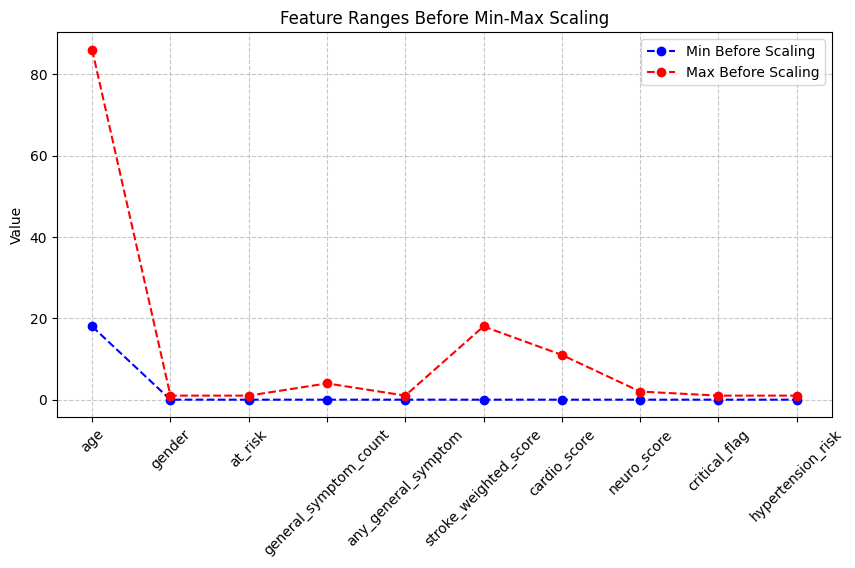

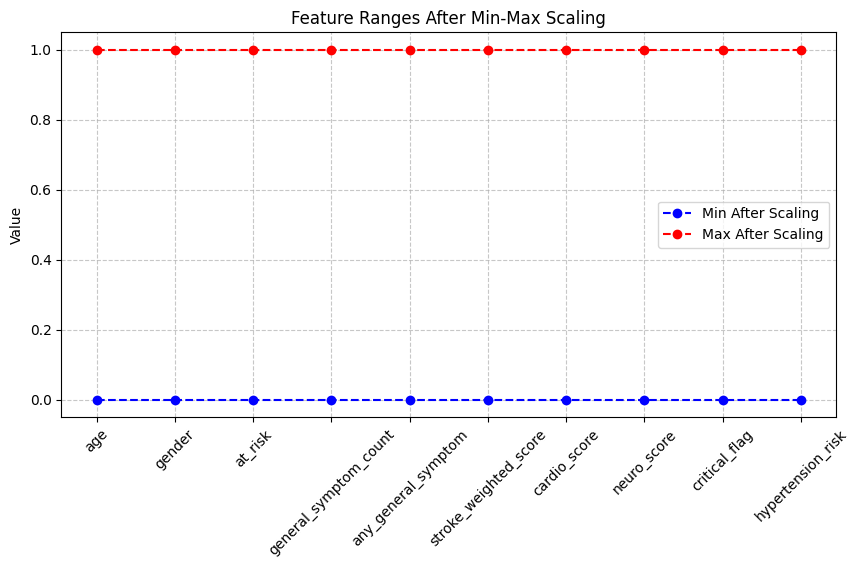

In [19]:
#Scaling/ Normalization 
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 2]

# Save min/max before scaling
min_before = df[numeric_cols].min()
max_before = df[numeric_cols].max()

# Plot feature ranges before scaling
plt.figure(figsize=(10,5))
plt.plot(numeric_cols, min_before.values, marker='o', linestyle='--', color='blue', label='Min Before Scaling')
plt.plot(numeric_cols, max_before.values, marker='o', linestyle='--', color='red', label='Max Before Scaling')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.title('Feature Ranges Before Min-Max Scaling')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

mms = MinMaxScaler()
df[[c for c in continuous_cols]] = mms.fit_transform(df[continuous_cols])

# Plot feature ranges after scaling
min_after = df[numeric_cols].min()
max_after = df[numeric_cols].max()

plt.figure(figsize=(10,5))
plt.plot(numeric_cols, min_after.values, marker='o', linestyle='--', color='blue', label='Min After Scaling')
plt.plot(numeric_cols, max_after.values, marker='o', linestyle='--', color='red', label='Max After Scaling')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.title('Feature Ranges After Min-Max Scaling')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

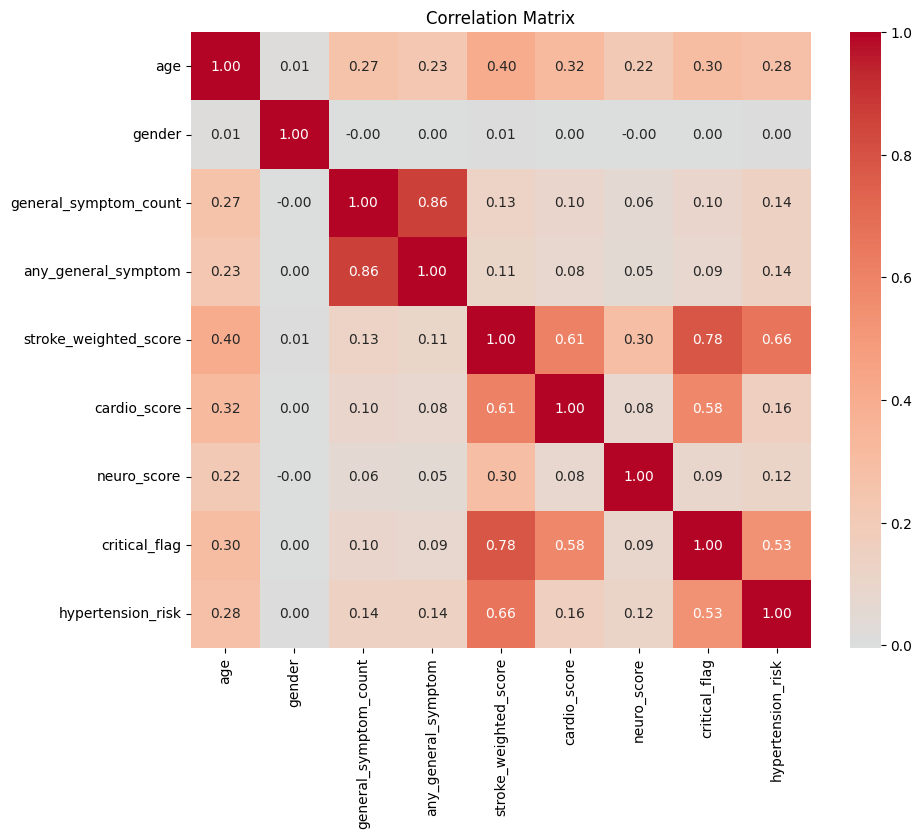

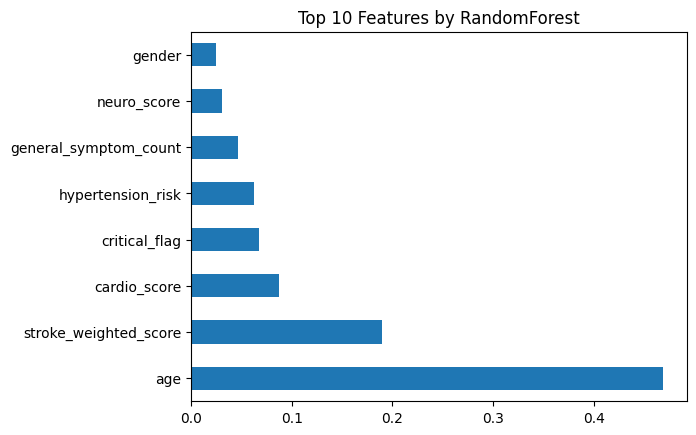

Selected features: ['age', 'general_symptom_count', 'any_general_symptom', 'stroke_weighted_score', 'cardio_score', 'neuro_score', 'critical_flag', 'hypertension_risk']
Feature selection complete.


In [20]:
# Feature Selection 

X = df.drop(columns=['at_risk'])
y = df['at_risk']

# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# RandomForest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(8).plot.barh()
plt.title("Top 10 Features by RandomForest")
plt.show()

# SelectKBest (Chi2)
selector = SelectKBest(chi2, k=8)
X_new = selector.fit_transform(X, y)
selected_cols = X.columns[selector.get_support()]
print("Selected features:", list(selected_cols))

df = pd.concat([df[selected_cols], y], axis=1)
print("Feature selection complete.")

Class balance before:
 at_risk
0    22113
1    12887
Name: count, dtype: int64


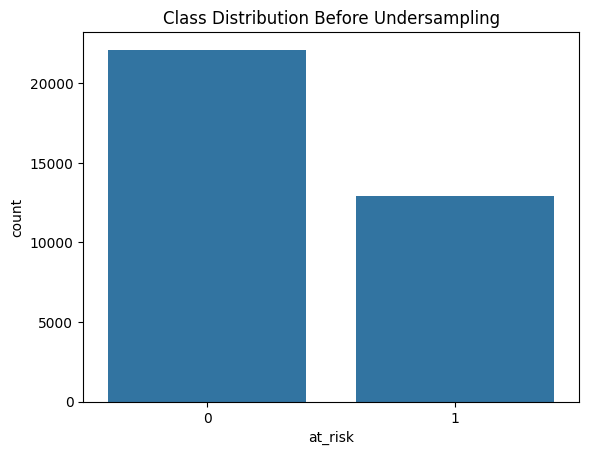

Class balance after undersampling:
 at_risk
0    10310
1    10310
Name: count, dtype: int64


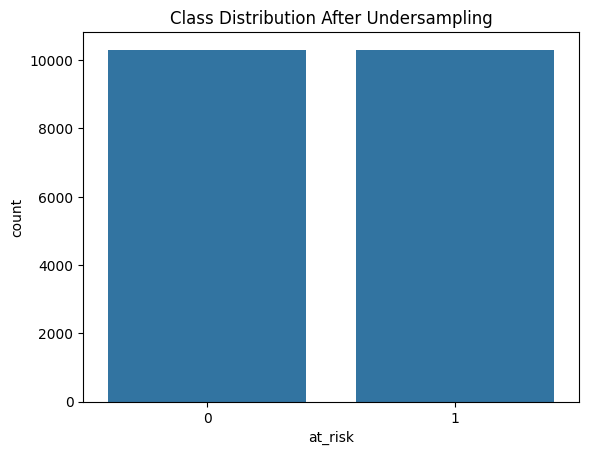

In [21]:
# Handling Imbalance

# Check class balance before
print("Class balance before:\n", df['at_risk'].value_counts())
sns.countplot(x='at_risk', data=df)
plt.title("Class Distribution Before Undersampling")
plt.show()

# Train-test split
X = df.drop(columns=['at_risk'])
y = df['at_risk']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply Random UnderSampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Check balance after undersampling
print("Class balance after undersampling:\n", pd.Series(y_res).value_counts())
sns.countplot(x=y_res)
plt.title("Class Distribution After Undersampling")
plt.show()

In [22]:
# Save outputs
X_res.to_csv(os.path.join(DATA_PROCESSED, "X_train.csv"), index=False)
y_res.to_csv(os.path.join(DATA_PROCESSED, "y_train.csv"), index=False)
X_test.to_csv(os.path.join(DATA_PROCESSED, "X_test.csv"), index=False)
y_test.to_csv(os.path.join(DATA_PROCESSED, "y_test.csv"), index=False)

print("Full preprocessing pipeline complete and saved")

Full preprocessing pipeline complete and saved
